# Research Methodology (Summary)

# Data Importation

In [1]:
import numpy as np
from scipy.io import loadmat
import pandas as pd
import antropy as ant
from collections import namedtuple
import pywt
from math import floor
from scipy import stats
import matplotlib.pyplot as plt

In [67]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import the data for patient 1
dict_ = loadmat('./Class A train sets/2_EEG200908190811.mat')
dict_.keys()

dict_keys(['__header__', '__version__', '__globals__', 'BIS', 'x', 'CH2', 'Denoised_x', 'CH2Denoised_x'])

<br/>

# Windowing

In [5]:
# Generate the windows
def generate_samples(bis, eeg, window_size=60, sampling_rate=128, verbose=False):
    """
    Generates EEG samples for consecutive windows 
    and their corresponding BIS value
    
    
    Parameters
    ----------       
    eeg: (n,) array. 
        EEG Sample. 
        
    bis: (n,) array
        BIS Sample
        
    window_size: int, default: 5 
        Duration of each window in seconds
        
    sampling_rate: float default: 128
        Sampling rate of the EEG sample in Hz.
        
    
    Generates
    ---------
    tup: tuple(bis_mode, eeg_sample)
    
        bis_mode: float
            Modal BIS value of the EEG Sample
        
        eeg_sample: array
            EEG Sample for a 5 second window
        
        
        
    Example
    -------
    >>> awake = np.array([82.8])
    >>> eeg = array([ 0.17727497,  0.17783894,  0.17834346,  0.17878847,  0.17917353,
        0.17949788,  0.17976084,  0.17996202,  0.18010136,  0.18017881, ...])
       
    >>> # Create the generator
    >>> gen_sample = generate_samples(bis, eeg)
    
    >>> # Generate EEG sample
    >>> sample = next(gen_sample)
    
    
    Notes
    -----
    The function works well with the generate_DFTParameters function.
    
    >>> generate_DFTParameters(sample)
    [0.075986      0.206614     0.405465      1.290984      0.980829       84.5]
    
    """
    
    bis_len = len(bis)
    
    if bis_len < window_size:
        print("Length of BIS values must be greater than {}".format(window_size))
        return    

    
    start, end = 0, window_size
    
    eeg_start, eeg_end = 0, end * sampling_rate
    
    
    while True:
        if end > bis_len:
            break
        
        bis_idx = bis[start:end][-1][0]
        
        eeg_sample = eeg[eeg_start:eeg_end]
        
        data = namedtuple('EEG_Sample', ['eeg', 'bis'])
        
        tup = data(eeg_sample, bis_idx)
        
        if verbose:
            print("EEG Start: {} - {}".format(eeg_start, eeg_end))
        
        yield tup
        
        # update ranges
        start += 1
        end += 1
        
        eeg_start = start * sampling_rate
        eeg_end = end * sampling_rate
        
        


    

<br/>

## Testing <code>generate_samples</code>

We have to make sure that 60th BIS value for this patient - **82.9**, is the first value generated by the generator.

In [6]:
# Get the data
bis = dict_.get('BIS')
eeg_sample = np.ravel(dict_.get('CH2Denoised_x'))

In [7]:
# Create the generator
test_generator = generate_samples(bis, eeg_sample, verbose=True)

test_sample = next(test_generator)

print("First BIS index: ", test_sample.bis)

# Check that BIS values are only recorded after 60 seconds
# The 60th BIS is 82.9 for this patient
assert test_sample.bis == bis[59] == 82.9

EEG Start: 0 - 7680
First BIS index:  82.9


<br/>

# Feature Extraction

## DFT <code>generate_DFTParameters</code>

In [8]:
def generate_DFTParameters(eeg_sample, sampling_rate=128):
    """
    Generate the DFT parameters of EEG segments
    
    
    Parameters
    ----------
    eeg_sample: namedtuple('EEG_Sample', ['eeg', 'bis'])
    
        eeg: (n,) array 
            EEG Data
            
        bis: float
            Bispectral Index
            
        
    sampling_rate: int
        Sampling rate of the EEG segment
        
        
    Returns
    -------
    df : pd.DataFrame
        DataFrame of EEG parameters
        
    
    Notes
    -----
    Works well with the generate_samples function. See the documentation on generate_samples.
    """
    
    # amplitudes
    fft_values = np.absolute(np.fft.rfft(eeg_sample.eeg))

    # frequencies
    fft_freq = np.fft.rfftfreq(len(eeg_sample.eeg), 1.0/sampling_rate)
    
    # Analysing the bands
    eeg_bands = {'Delta': (0, 4),
                 'Theta': (4, 8),
                 'Alpha': (8, 12),
                 'Beta': (12, 30),
                 'Gamma': (30, 45)}

    eeg_band_fft = dict()

    for band in eeg_bands.keys():
        freq_idx = np.where((fft_freq >= eeg_bands[band][0]) & (fft_freq <= eeg_bands[band][1]))

        # sum the amplitudes of the bands
        eeg_band_fft[band] = fft_values[freq_idx]
        
    
    # Sample entropy of the delta band
    sampen_delta = ant.sample_entropy(eeg_band_fft['Delta'])
    sampen_beta = ant.sample_entropy(eeg_band_fft['Beta'])
    sampen_theta = ant.sample_entropy(eeg_band_fft['Theta'])
    sampen_gamma = ant.sample_entropy(eeg_band_fft['Gamma'])
    sampen_alpha = ant.sample_entropy(eeg_band_fft['Alpha'])
    
    
    # produce DataFrame of DFT Parameters
    #  columns=["Sampen_Delta", "Sampen_Beta", "Sampen_Theta", "Sampen_Gamma", "Sampen_Alpha", "BIS"]
    params = [sampen_delta, sampen_beta, sampen_theta, sampen_gamma, sampen_alpha, eeg_sample.bis]
    
    return params
    
    
    

<br/>

## DWT <code>generate_DWTParameters</code>

In [9]:
def generate_DWTParameters(eeg_sample, wavelet="db4"):
    
    """
    Generate the DWT Parameters of an EEG Sample
    
    
    Parameters
    -----------
    eeg_sample: namedtuple('EEG_Sample', ['eeg', 'bis'])
    
        bis: float
            Bispectral Index
            
        eeg: (n,) array 
            EEG Data
            
            
    wavelet: String; default="db4"
        Wavelet to use
    
    
    dec_level: int; default=4
        Decomposition level 
    

    """
    # Approximate and Detailed Coefficients
    cA_4, cD_4, cD_3, cD_2, cD_1 = pywt.wavedec(eeg_sample.eeg, wavelet, level=4)
    
    
    # Sample Entropy of the sub-bands
    sampen_cA_4 = ant.sample_entropy(cA_4)
    sampen_cD_4 = ant.sample_entropy(cD_4)
    sampen_cD_3 = ant.sample_entropy(cD_3)
    sampen_cD_2 = ant.sample_entropy(cD_2)
    sampen_cD_1 = ant.sample_entropy(cD_1)
    
    
    # produce DataFrame of DWT Parameters
    # columns=["SampenCA_4", "SampenCD_4", "SampenCD_3", "SampenCD_2", "SampenCD_1", "BIS"]
    params = [sampen_cA_4, sampen_cD_4, sampen_cD_3, sampen_cD_2, sampen_cD_1, eeg_sample.bis]
    
    return params
    
    


<br/>

# Dataset Creation

## DFT

In [49]:
# Generator that creates EEG samples
gen = generate_samples(bis, eeg_sample)

# Creating the dataset
dft_dataset = [generate_DFTParameters(sample) for sample in gen]

# Dataset
df_dft = pd.DataFrame(dft_dataset, columns=["Sampen_Delta", "Sampen_Beta", "Sampen_Theta", "Sampen_Gamma", "Sampen_Alpha", "BIS"])


In [53]:
df_dft.index = df_dft.index + 60
df_dft.head()

Sampen_Delta  Sampen_Beta  Sampen_Theta  Sampen_Gamma  Sampen_Alpha   BIS
60      0.658150     1.383708      2.252794      1.857730      2.248364  82.9
61      0.645138     1.367389      2.320604      1.819686      2.147214  83.1
62      0.651460     1.358295      2.085376      1.868316      2.354172  83.1
63      0.659378     1.371857      2.194296      1.868755      2.131627  83.1
64      0.666993     1.378257      2.507972      1.858673      2.403938  83.2

<br/>

## DWT

In [54]:
# Generator that creates EEG samples
gen = generate_samples(bis, eeg_sample)

# Creating the dataset
dwt_dataset = [generate_DWTParameters(sample) for sample in gen]

# Dataset
df_dwt = pd.DataFrame(dwt_dataset, columns=["SampenCA_4", "SampenCD_4", "SampenCD_3", "SampenCD_2", "SampenCD_1", "BIS"])


In [57]:
df_dwt.index = df_dwt.index + 60
df_dwt.head()

SampenCA_4  SampenCD_4  SampenCD_3  SampenCD_2  SampenCD_1   BIS
60    0.621993    0.237041    0.280017    0.268769    0.263373  82.9
61    0.641179    0.267895    0.315545    0.296700    0.290703  83.1
62    0.715804    0.281023    0.346876    0.322381    0.313297  83.1
63    0.815288    0.324438    0.382209    0.355274    0.341692  83.1
64    0.861407    0.371853    0.426413    0.386343    0.367114  83.2

<br/>

# Week 3 Tasks

## Visualize parameters

In [13]:
# Training set
import os
training_set = [file for file in os.listdir("./Class A train sets") if ".mat" in file]

In [14]:
training_set

['31_EEG200909092.mat',
 '14_EEG200906220903.mat',
 '4_EEG200909160908.mat',
 '13_EEG20100609.mat',
 '19_EEG201004072.mat',
 '30_EEG200909091.mat',
 '2_EEG200908190811.mat',
 '32_EEG201004071.mat',
 '20_EEG201005241.mat',
 '7_EEG201005241657.mat',
 '3_EEG200908190921.mat']

In [16]:
# HELPER FUNCTION
def plot_graph(df_dft, df_dwt, graph_type=None):

    if graph_type == None:
        fig, ax = plt.subplots(2, 6, figsize=(30,10))
        dft_columns = ["Sampen_Delta", "Sampen_Beta", "Sampen_Theta", "Sampen_Gamma", "Sampen_Alpha", "BIS"]
        dwt_columns = ["SampenCA_4", "SampenCD_4", "SampenCD_3", "SampenCD_2", "SampenCD_1", "BIS"]


        # Plot DFT data
        for j in range(6):
            ax[0,j].plot(df_dft[dft_columns[j]])
            ax[0,j].set_xlabel("Samples")
            ax[0,j].set_ylabel(dft_columns[j])


        # Plot DWT data
        for i in range(6):
            if i == 5:
                ax[1,i].axis("off")
                break

            ax[1,i].plot(df_dwt[dwt_columns[i]])
            ax[1,i].set_xlabel("Samples")
            ax[1,i].set_ylabel(dwt_columns[i])



        plt.show()
        
        
    if graph_type == "scatter":
        fig, ax = plt.subplots(2, 6, figsize=(30,10))
        dft_columns = ["Sampen_Delta", "Sampen_Beta", "Sampen_Theta", "Sampen_Gamma", "Sampen_Alpha", "BIS"]
        dwt_columns = ["SampenCA_4", "SampenCD_4", "SampenCD_3", "SampenCD_2", "SampenCD_1", "BIS"]


        # Plot DFT data
        for j in range(6):
            
            if j == 5:
                ax[0,j].plot(df_dft[dft_columns[j]])
                ax[0,j].set_xlabel("Samples")
                ax[0,j].set_ylabel("BIS")
                break
            
            ax[0,j].scatter(df_dft[dft_columns[j]], df_dft['BIS'])
            ax[0,j].set_xlabel(dft_columns[j])
            ax[0,j].set_ylabel("BIS")


        # Plot DWT data
        for i in range(6):
            if i == 5:
                ax[1,i].axis("off")
                break

            ax[1,i].scatter(df_dwt[dwt_columns[i]], df_dft['BIS'])
            ax[1,i].set_xlabel(dwt_columns[i])
            ax[1,i].set_ylabel("BIS")



        plt.show()
    

In [17]:
def visualise_params(training_file, graph_type=None):
    
    """
    Make line and scatterplots as discussed with Dr. Li.
    
    
    Parameters
    ----------
    training_file: str
        The matlab file containing the EEG data
        
        
    graph_type: str, default None
        If graph_type is None, a line graph is plotted but if graph_type is 'scatter',
        a scatter plot of the BIS against each parameter is created.
    
    """
    
    # Load processed data if it exists
    try:
        df_dft = pd.read_csv("./Class A train sets/Processed Training Dataset/{}_DFT.csv".format(training_file))
        dwt_dft = pd.read_csv("Class A train sets/Processed Training Dataset/{}_DWT.csv".format(training_file))
        
        plot_graph(df_dft, dwt_dft, graph_type)
        
        
    except FileNotFoundError:
        
        # Load the data from the file
        dict_ = loadmat('./Class A train sets/{}'.format(training_file))

        # Extract relevant data
        bis = dict_.get('BIS')
        eeg_sample = np.ravel(dict_.get('CH2Denoised_x'))

        # Generate EEG samples from the data
        gen_dft = generate_samples(bis, eeg_sample)

        # DFT data
        dft_dataset = [generate_DFTParameters(sample) for sample in gen_dft]

        # Generate EEG samples from the data
        gen_dwt = generate_samples(bis, eeg_sample)

        # DWT data
        dwt_dataset = [generate_DWTParameters(sample) for sample in gen_dwt]

        # Create dataset
        df_dft = pd.DataFrame(dft_dataset, columns=["Sampen_Delta", "Sampen_Beta", "Sampen_Theta", "Sampen_Gamma", "Sampen_Alpha", "BIS"])
        df_dwt = pd.DataFrame(dwt_dataset, columns=["SampenCA_4", "SampenCD_4", "SampenCD_3", "SampenCD_2", "SampenCD_1", "BIS"])

        # Reset their indexes
        df_dft.index = df_dft.index + 60
        df_dwt.index = df_dwt.index + 60

        # Save the data for future use
        print("Saving dataset for future use")
        print()
        df_dft.to_csv("./Class A train sets/Processed Training Dataset/{}_DFT.csv".format(training_file))
        df_dwt.to_csv("./Class A train sets/Processed Training Dataset/{}_DWT.csv".format(training_file))

        # Plotting the data
        print("Making relevant graphs for Patient {}".format(training_file))
        print("-------------------------------------------------------")


        plot_graph(df_dft, df_dwt, graph_type)
        

<br/>

<p style="font-size: 2rem; font-weight:bold; margin: 1rem 0">The DFT and DWT data for each patient is saved after processing as shown in the figure below.</p>

<img src="ProcessedImg.png" >

<br/>

File: 31_EEG200909092.mat

A plot of the Parameters
--------------------------


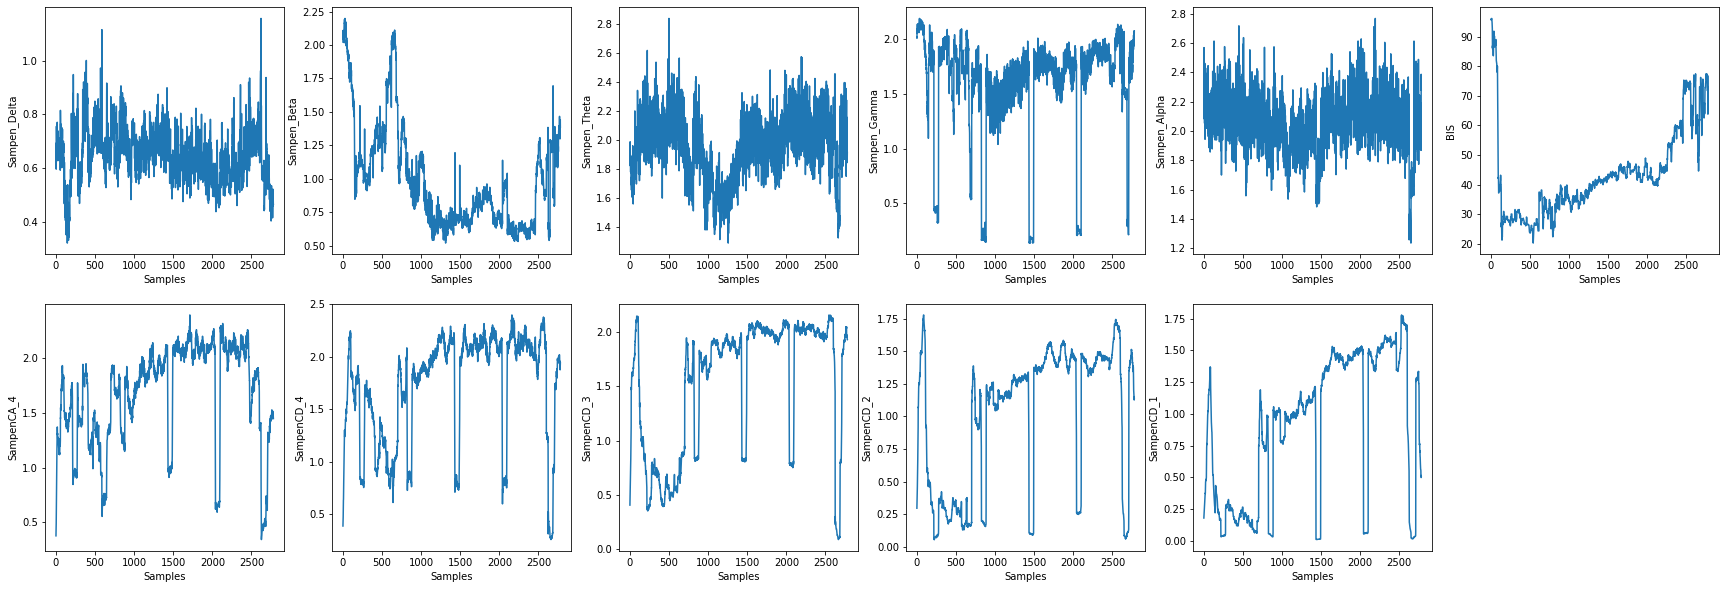

BIS against each parameter
--------------------------


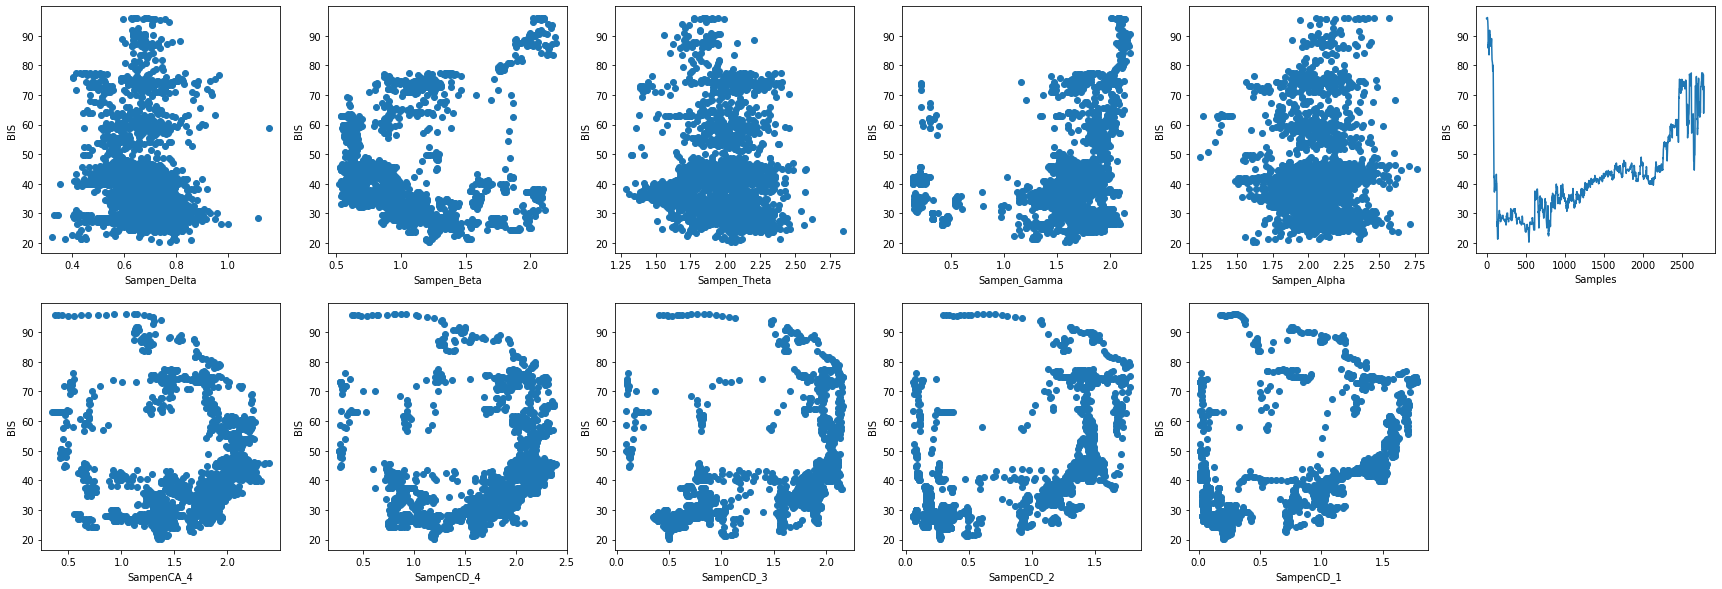



File: 14_EEG200906220903.mat

A plot of the Parameters
--------------------------


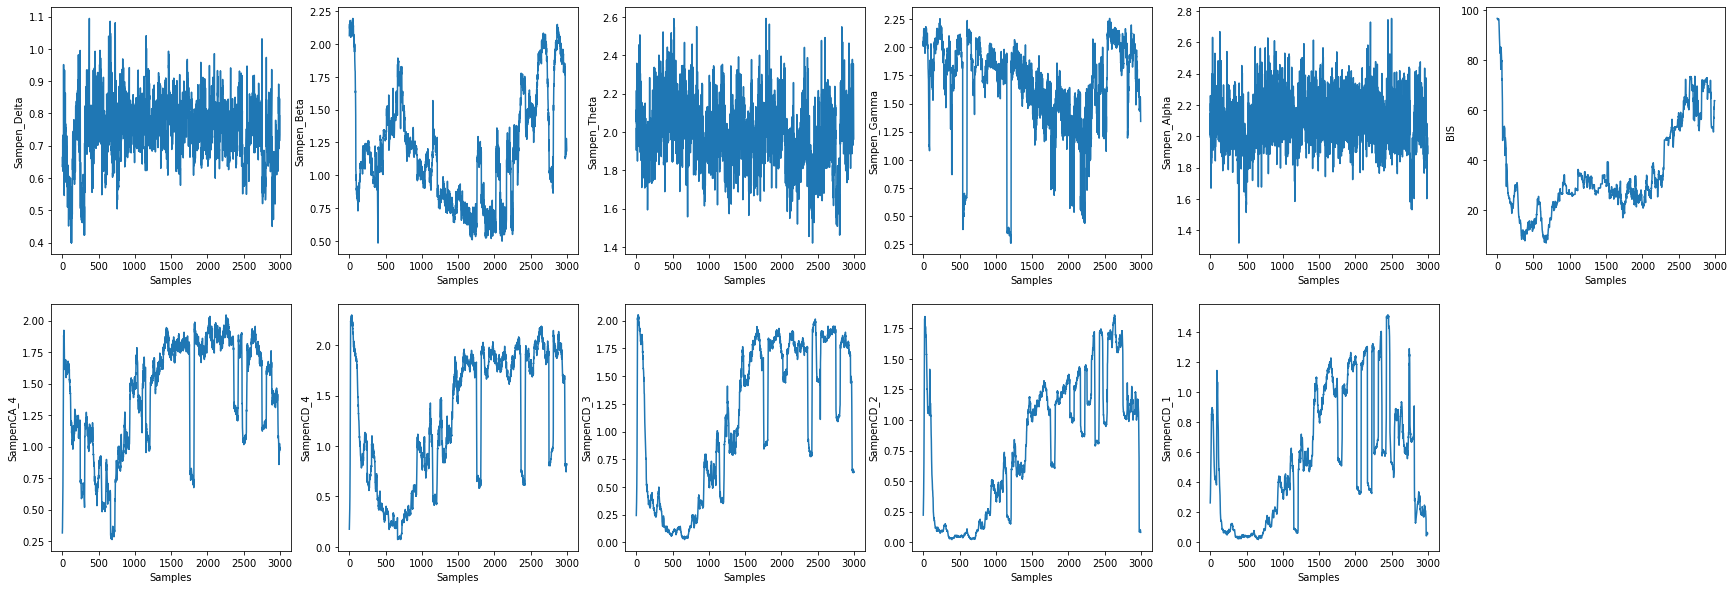

BIS against each parameter
--------------------------


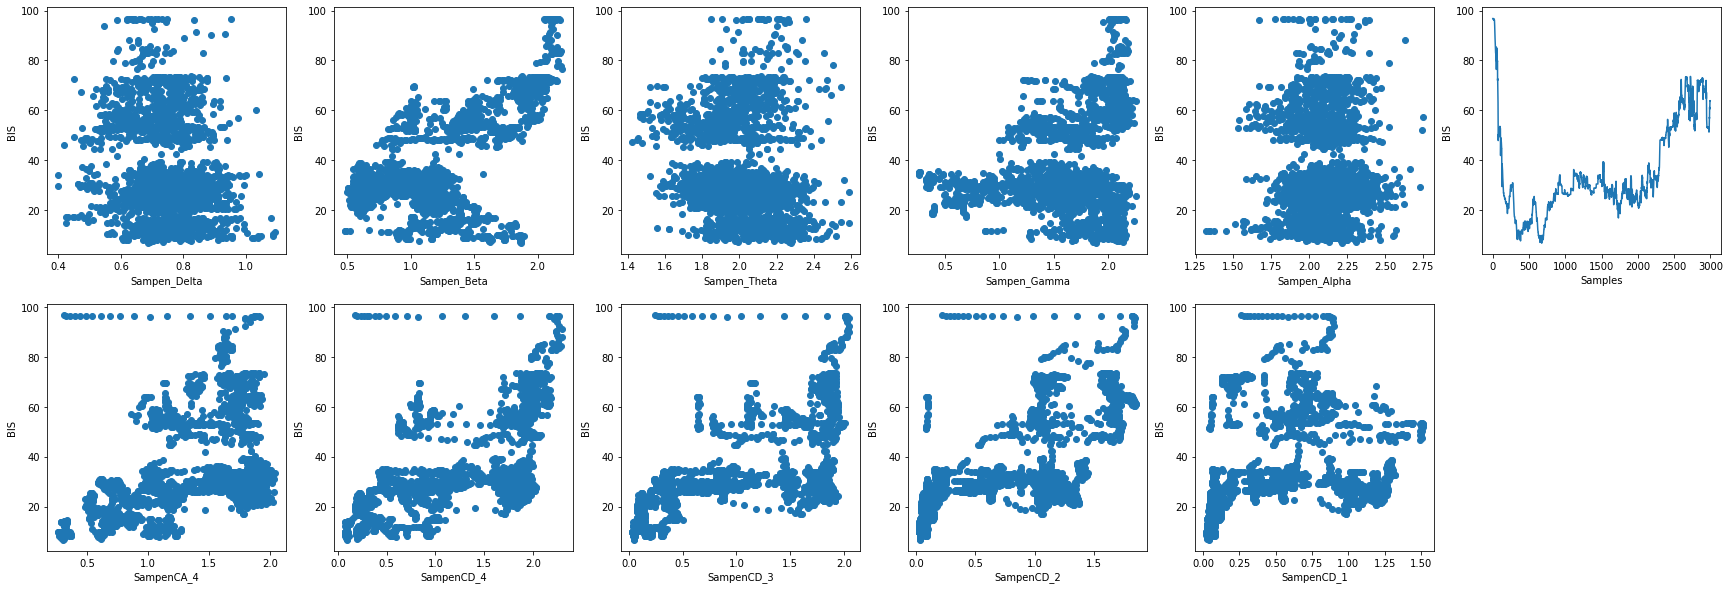



File: 4_EEG200909160908.mat

A plot of the Parameters
--------------------------


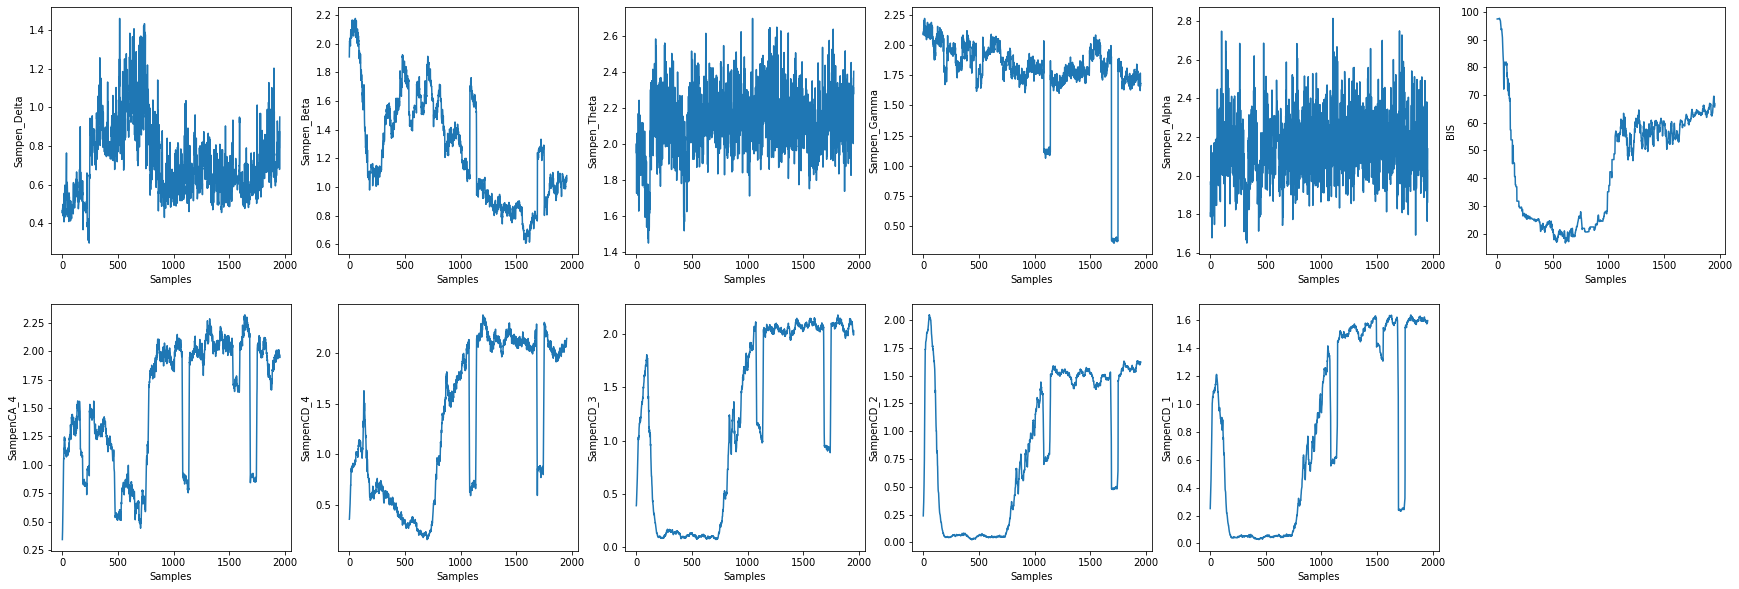

BIS against each parameter
--------------------------


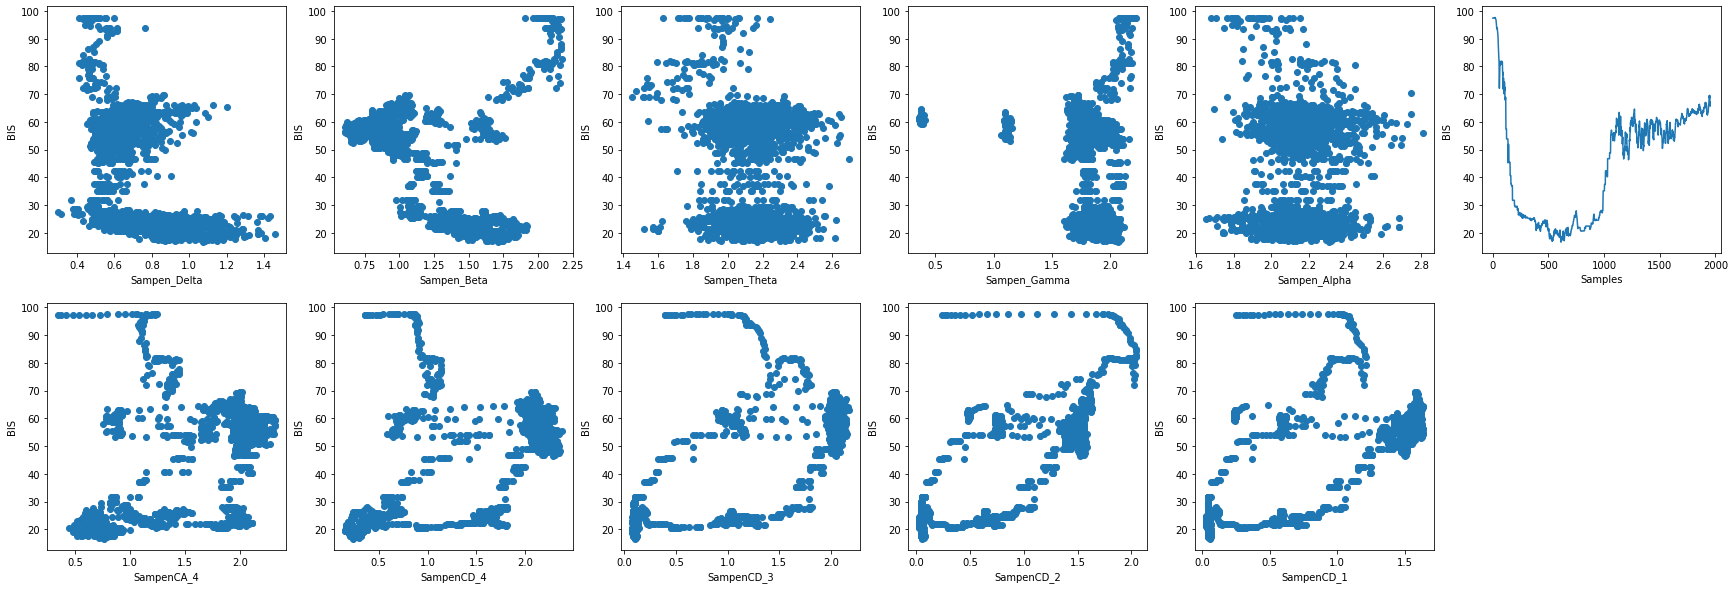



File: 13_EEG20100609.mat

A plot of the Parameters
--------------------------


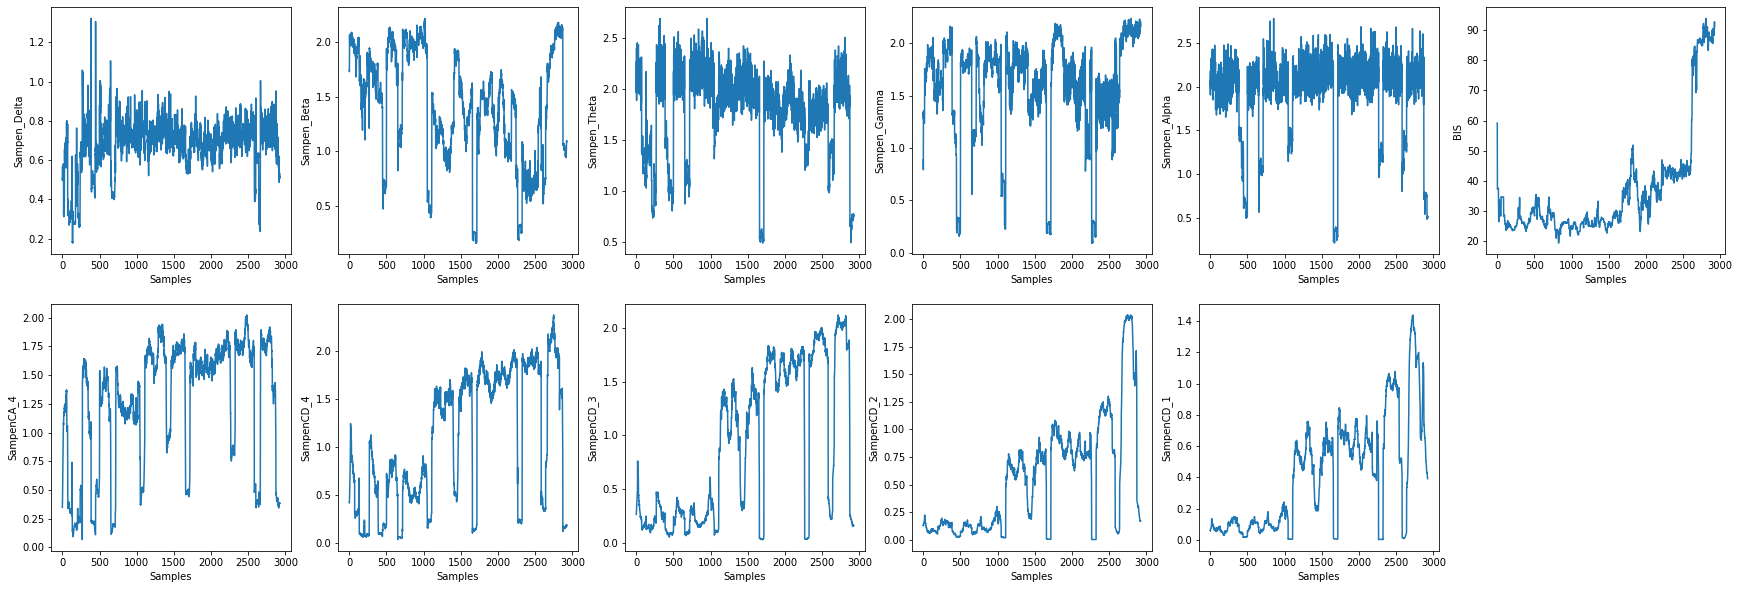

BIS against each parameter
--------------------------


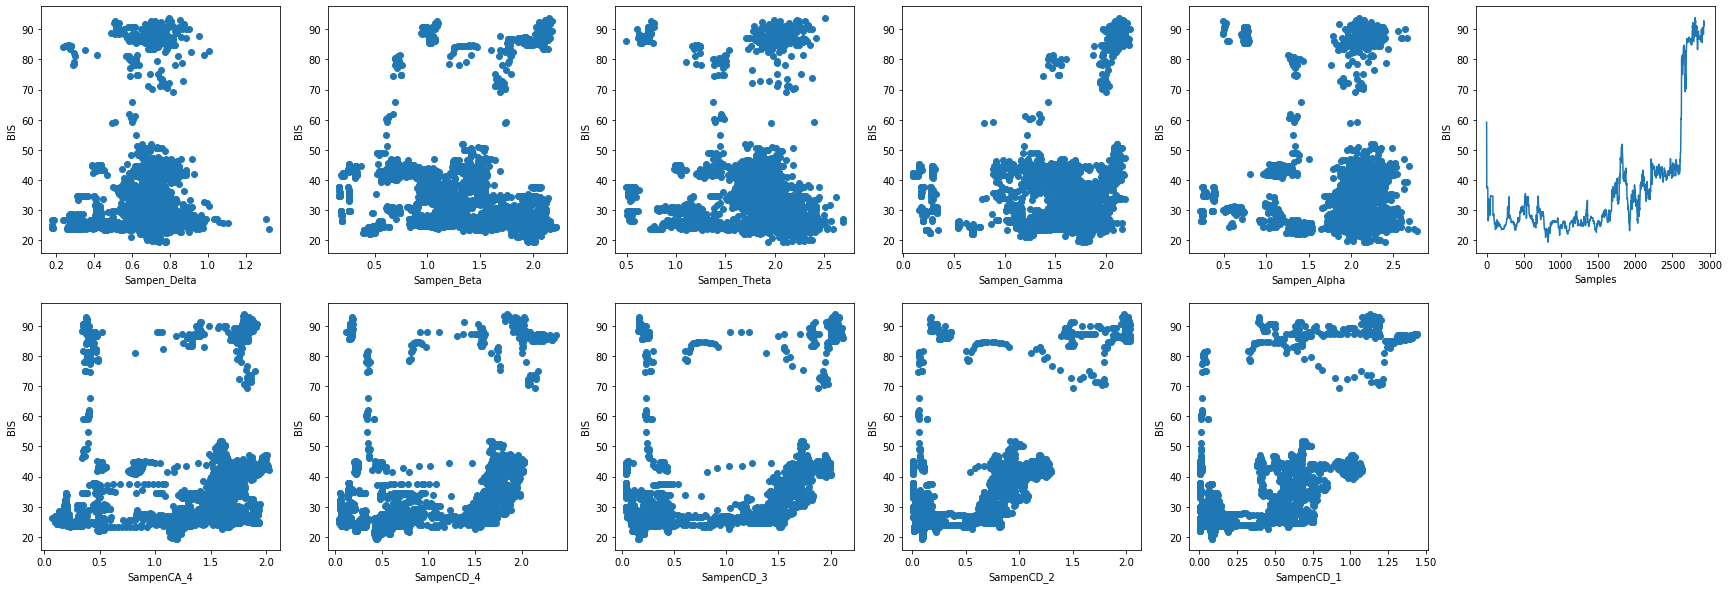



File: 19_EEG201004072.mat

A plot of the Parameters
--------------------------


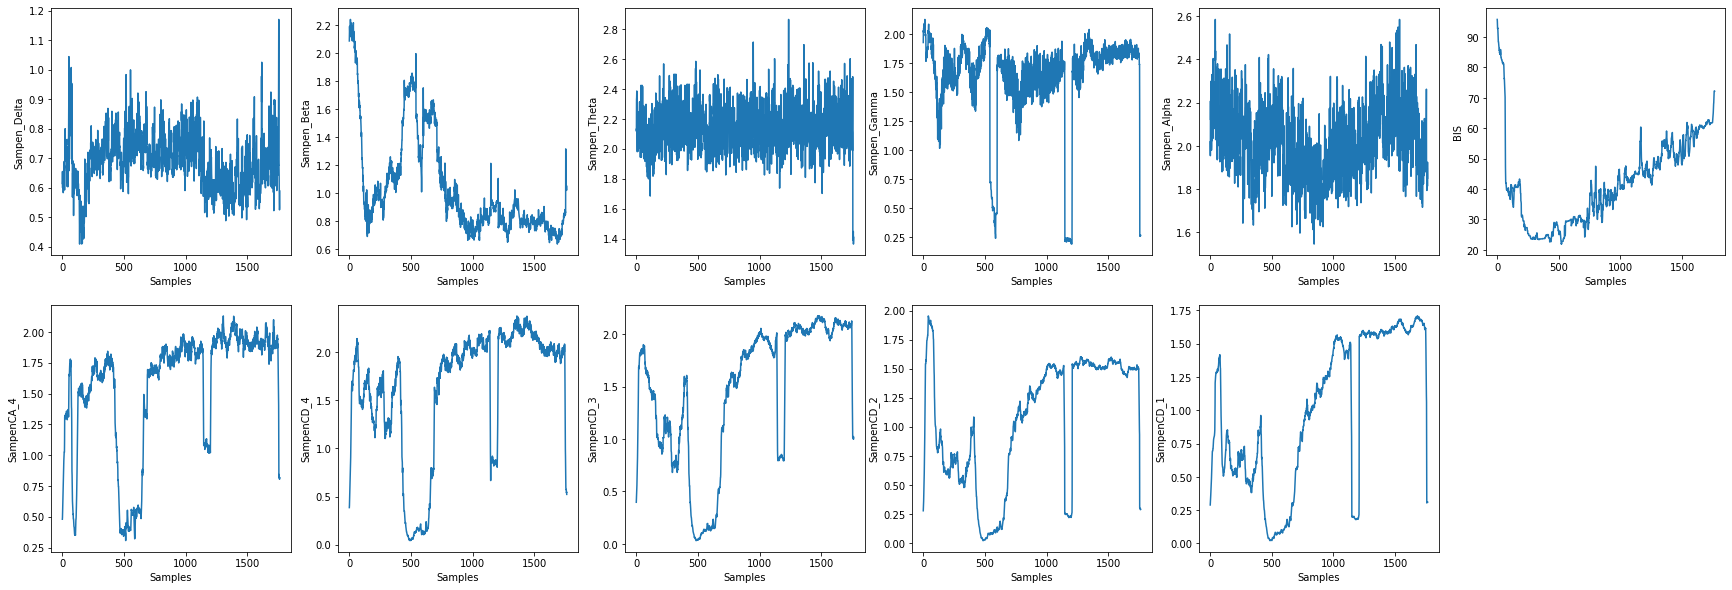

BIS against each parameter
--------------------------


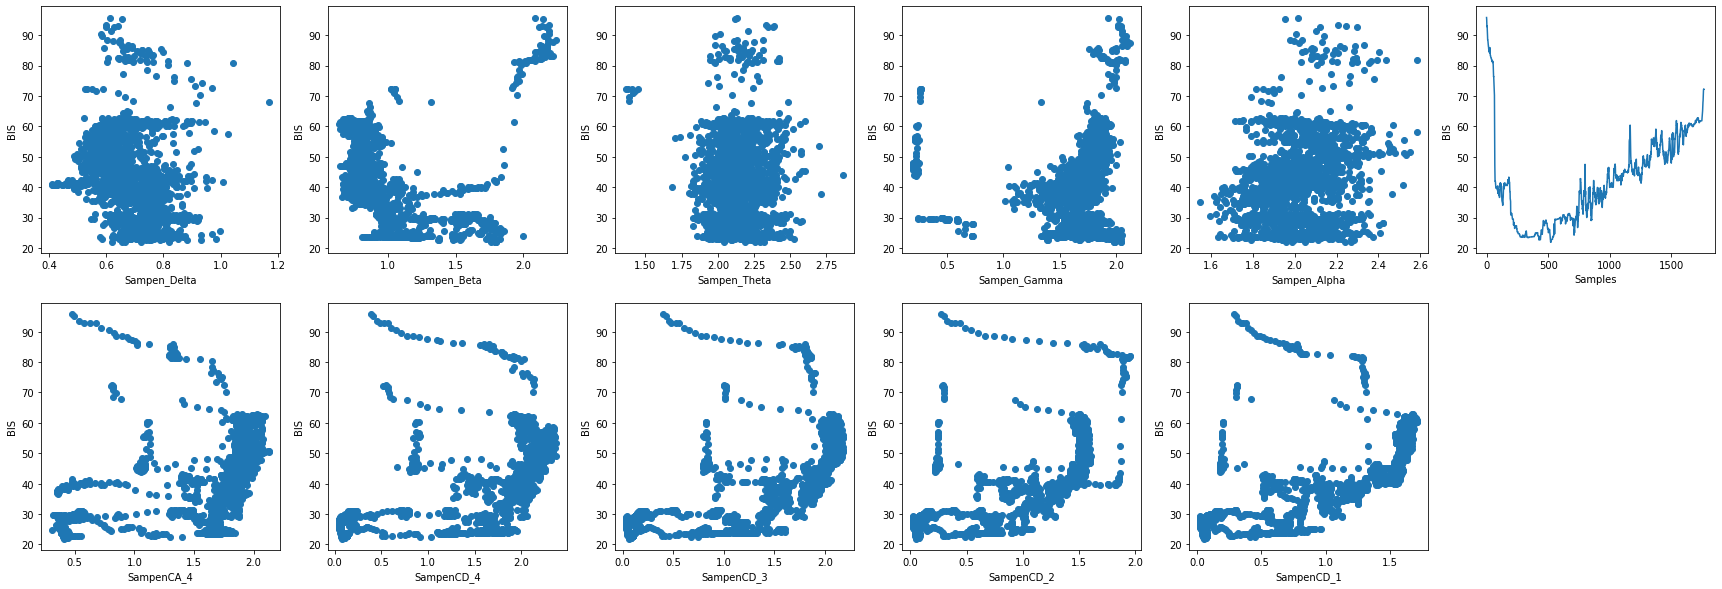



File: 30_EEG200909091.mat

A plot of the Parameters
--------------------------


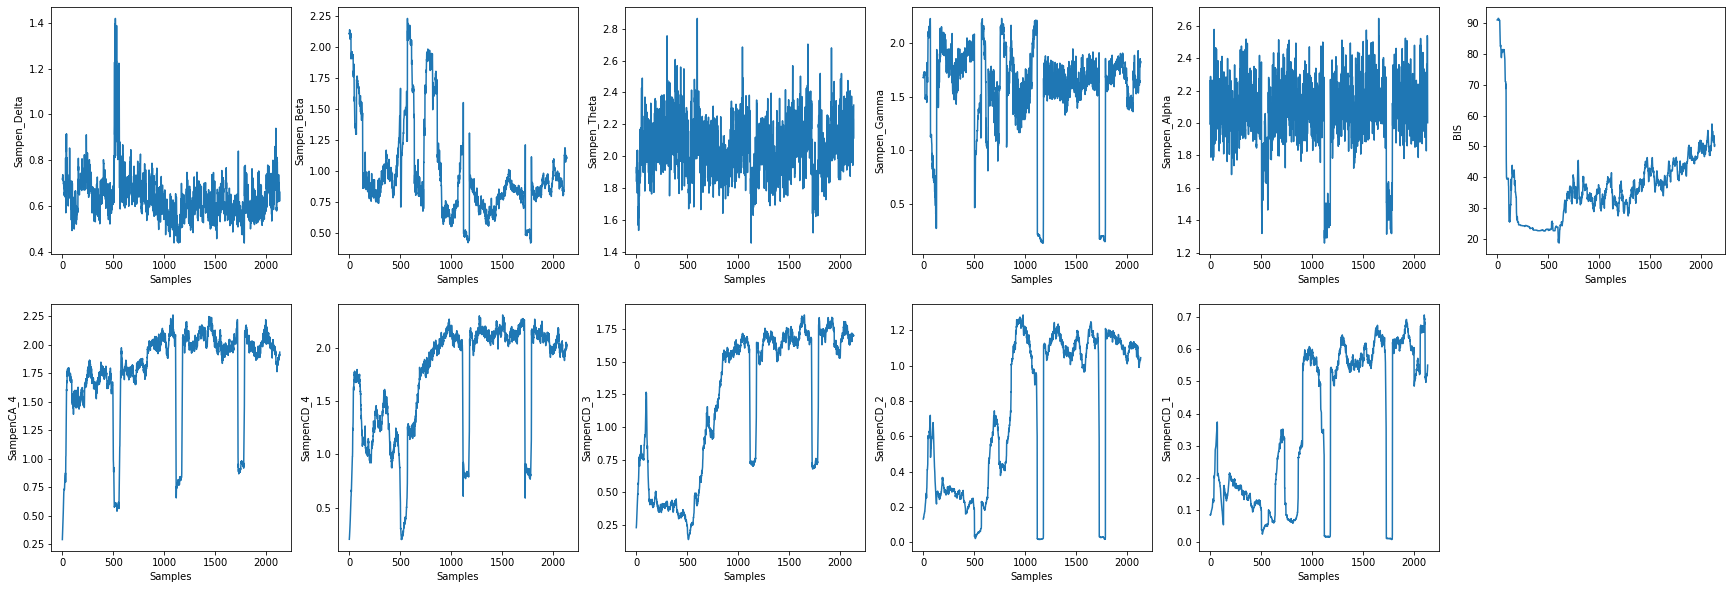

BIS against each parameter
--------------------------


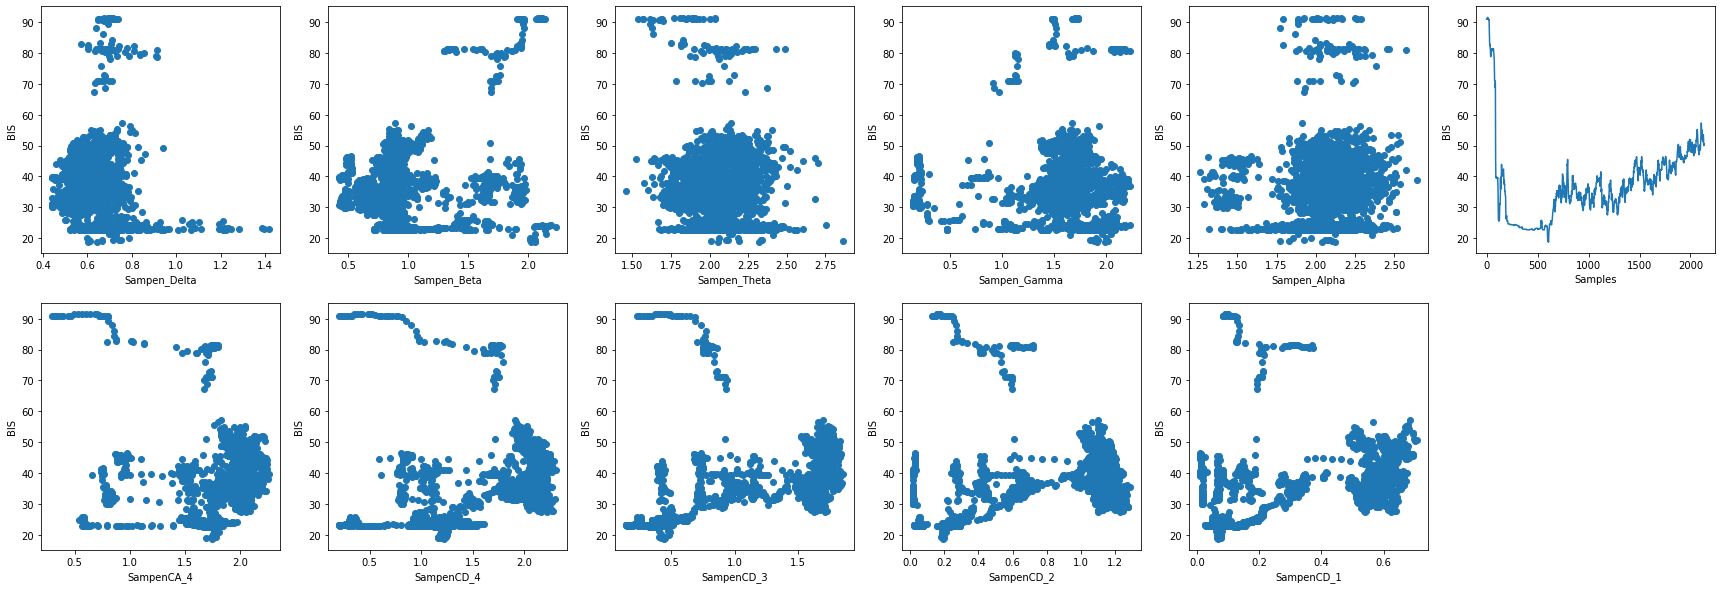



File: 2_EEG200908190811.mat

A plot of the Parameters
--------------------------


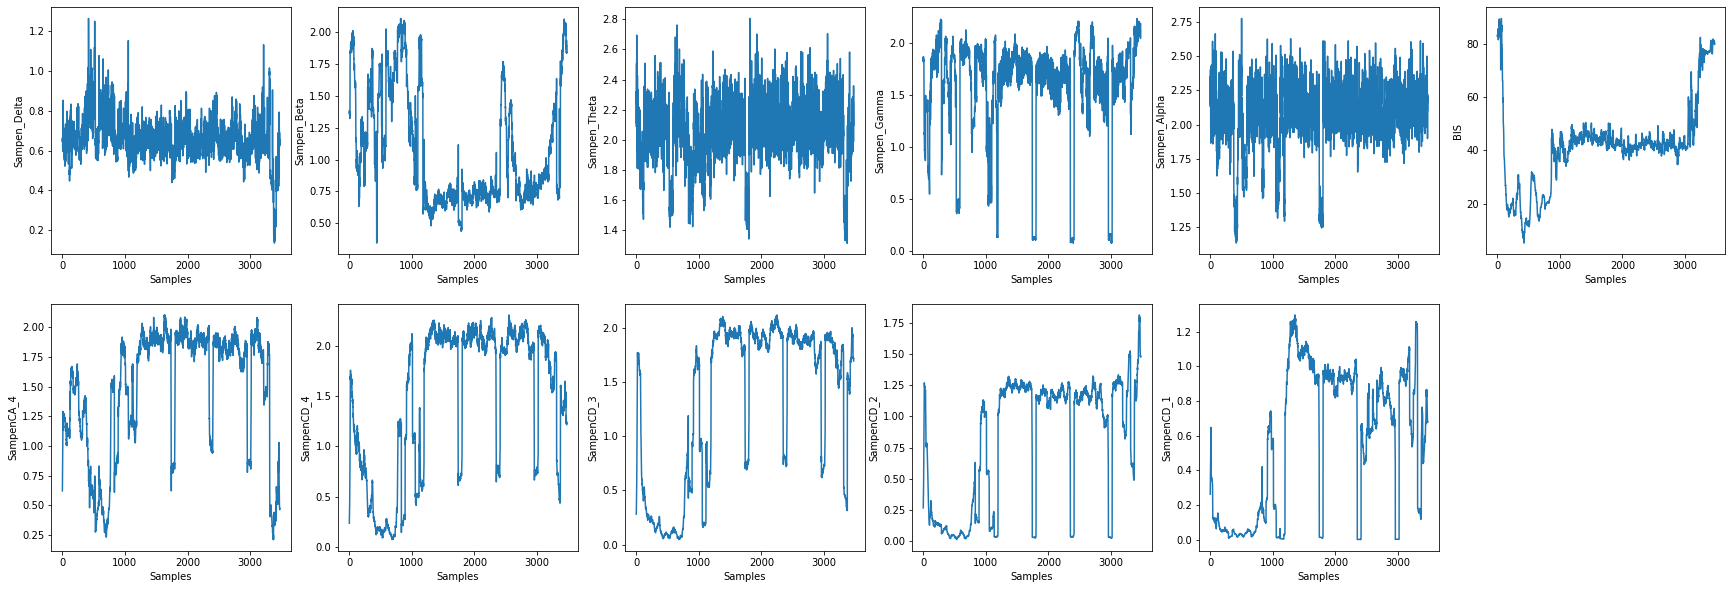

BIS against each parameter
--------------------------


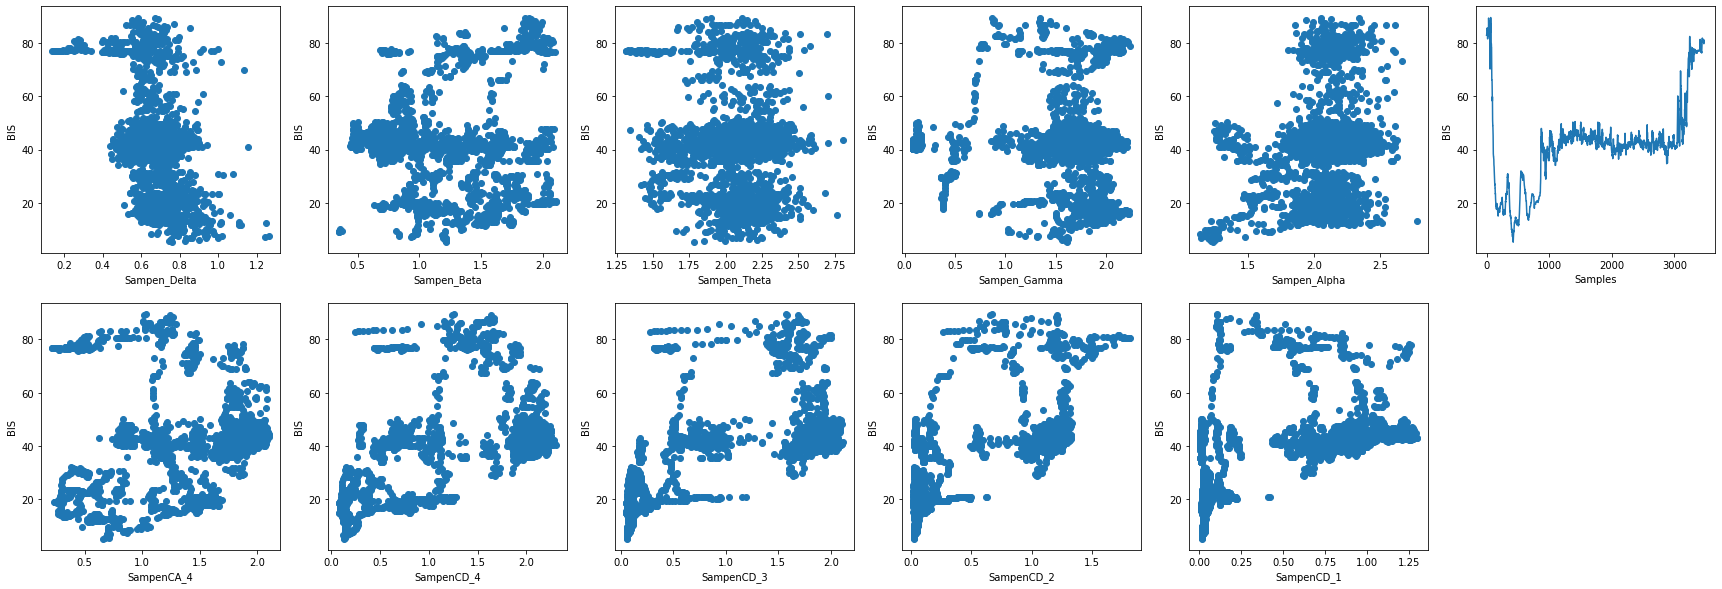



File: 32_EEG201004071.mat

A plot of the Parameters
--------------------------


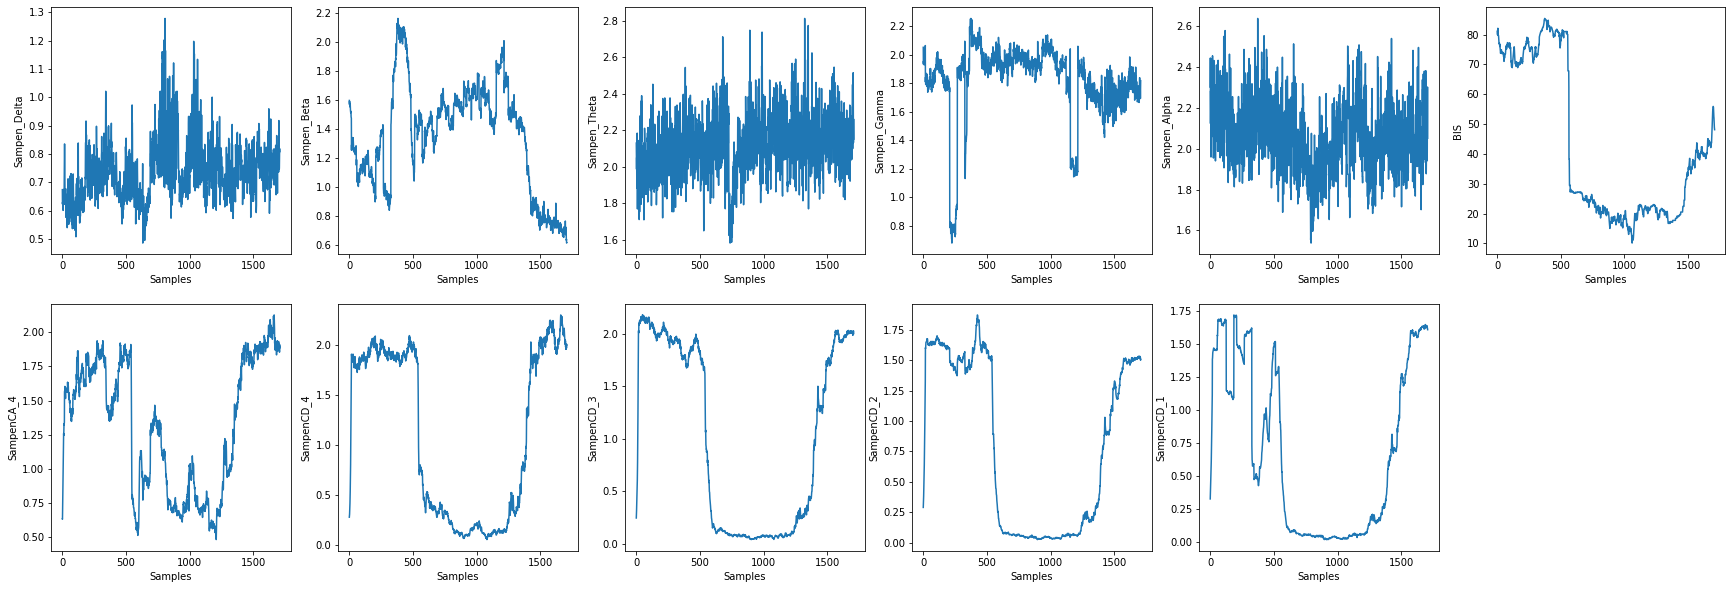

BIS against each parameter
--------------------------


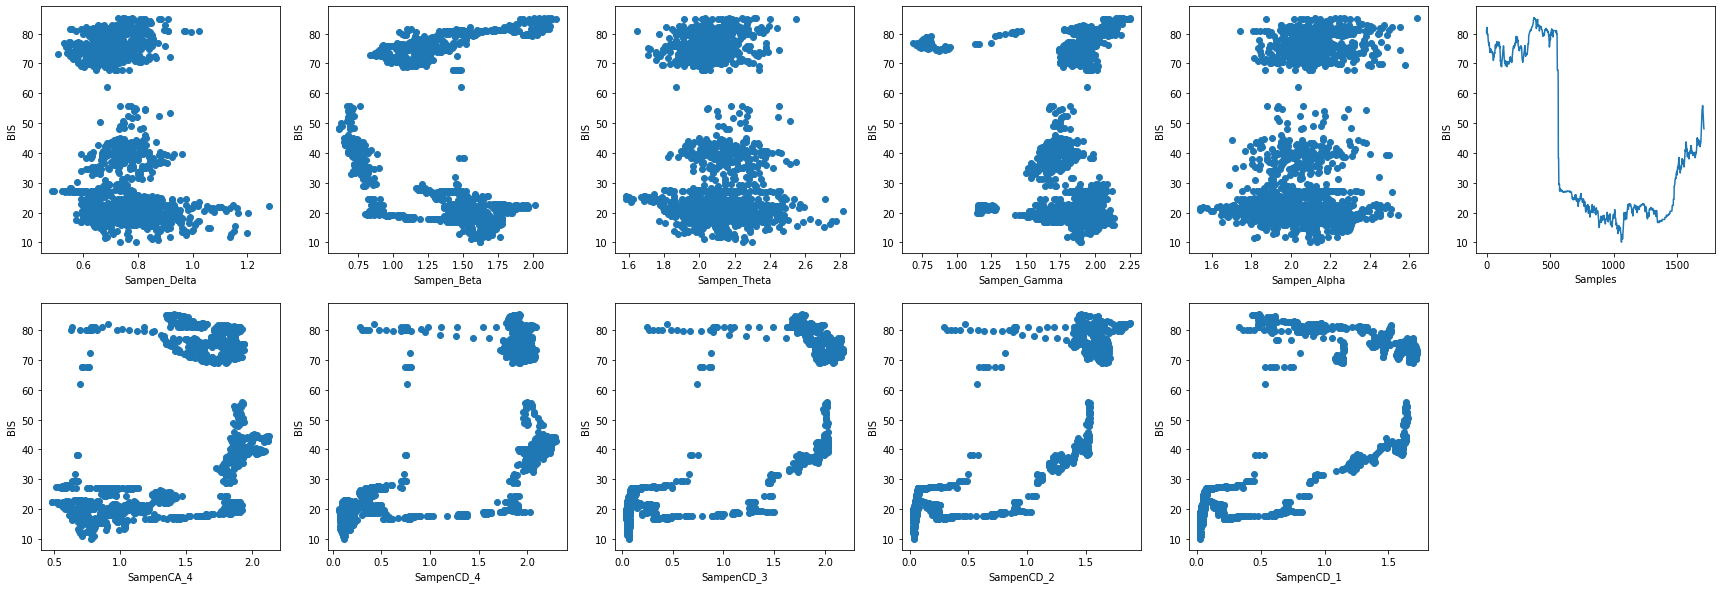



File: 20_EEG201005241.mat

A plot of the Parameters
--------------------------


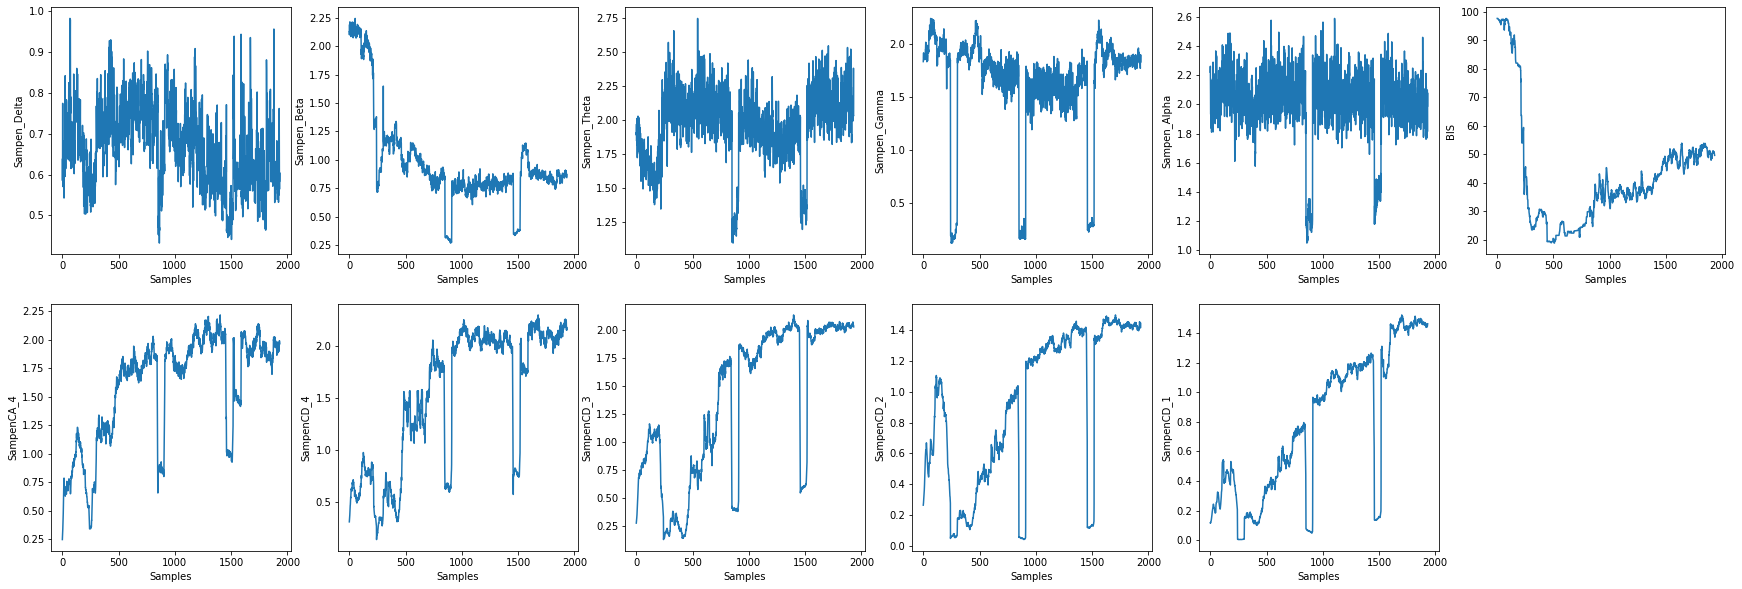

BIS against each parameter
--------------------------


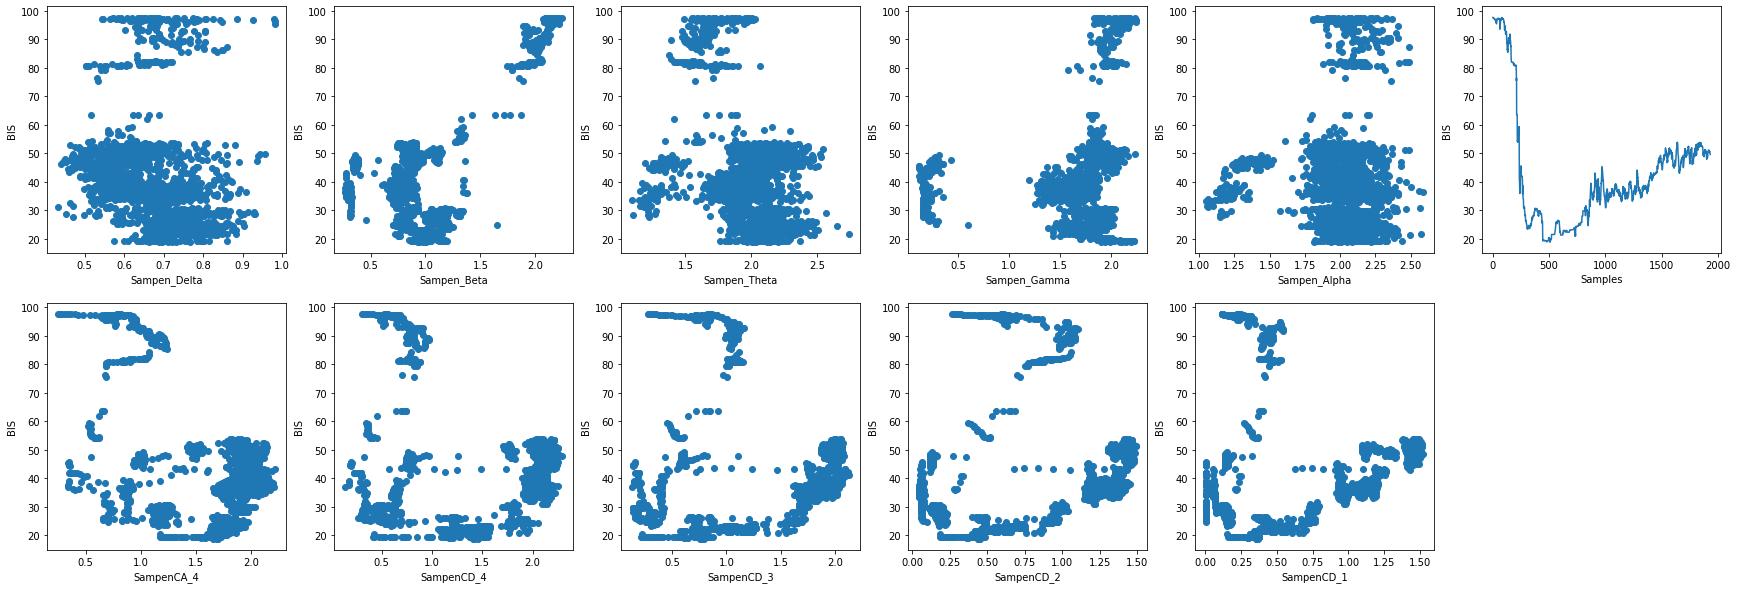



File: 7_EEG201005241657.mat

A plot of the Parameters
--------------------------


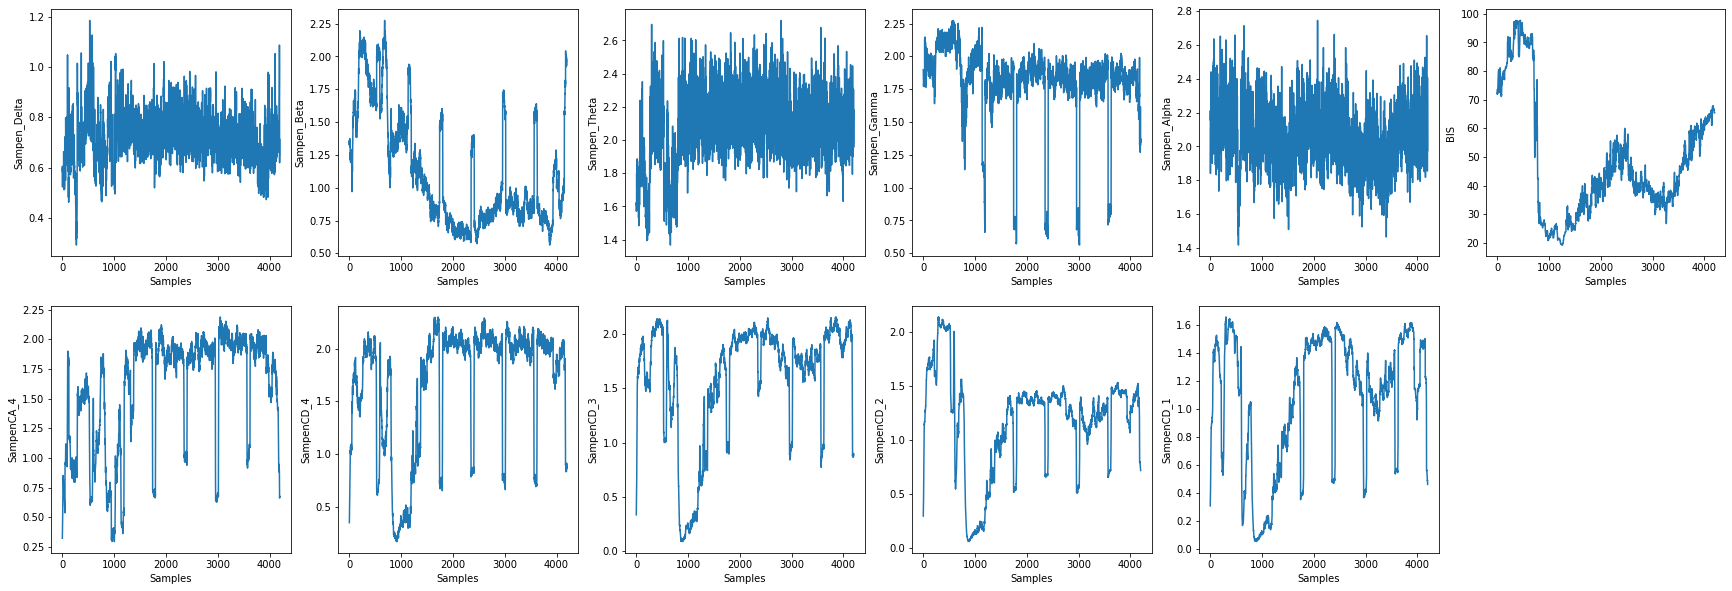

BIS against each parameter
--------------------------


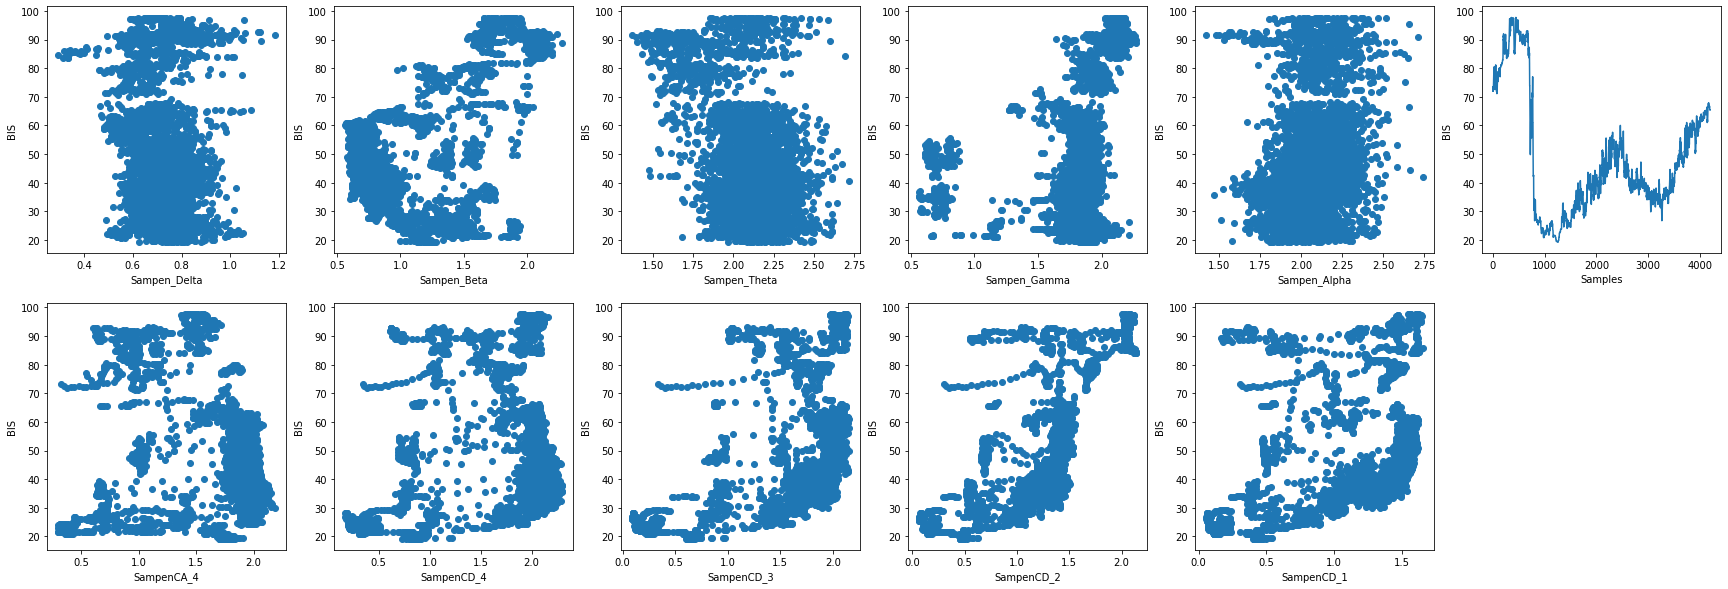



File: 3_EEG200908190921.mat

A plot of the Parameters
--------------------------


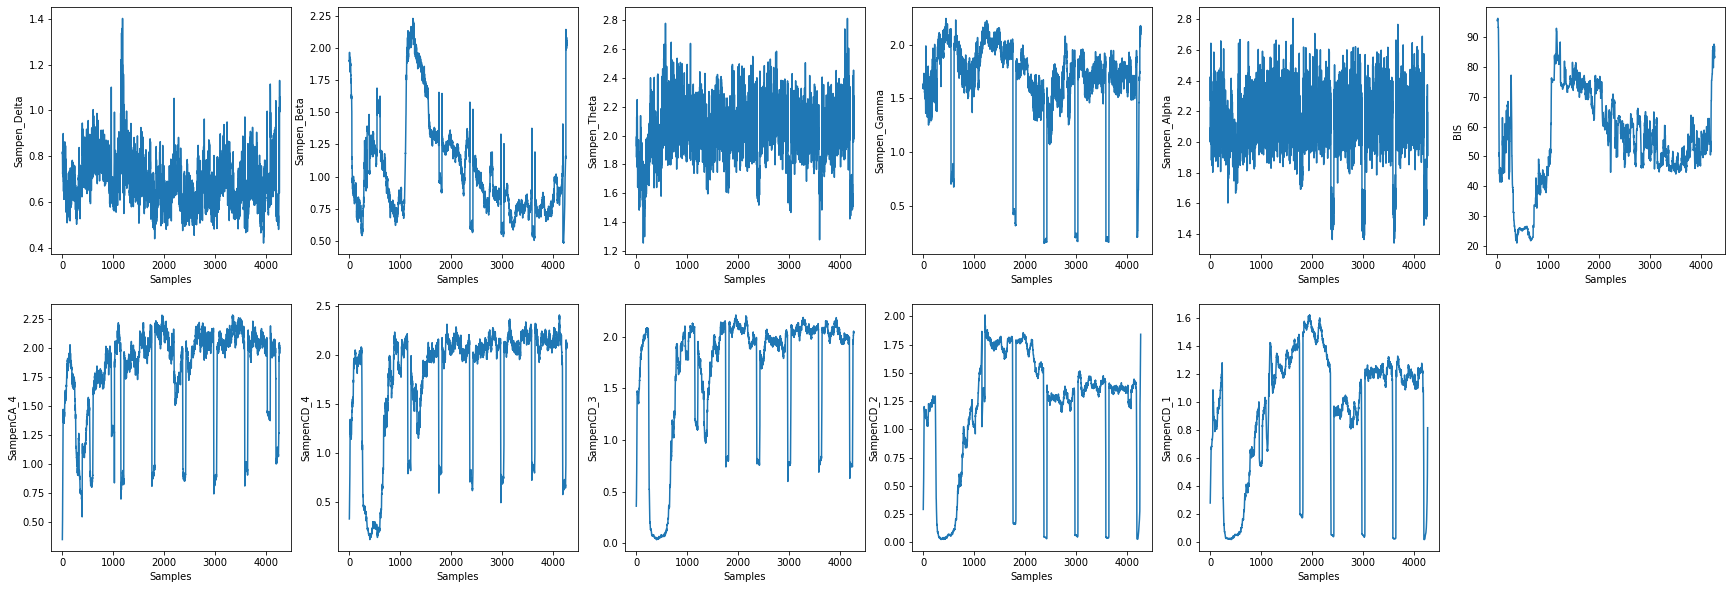

BIS against each parameter
--------------------------


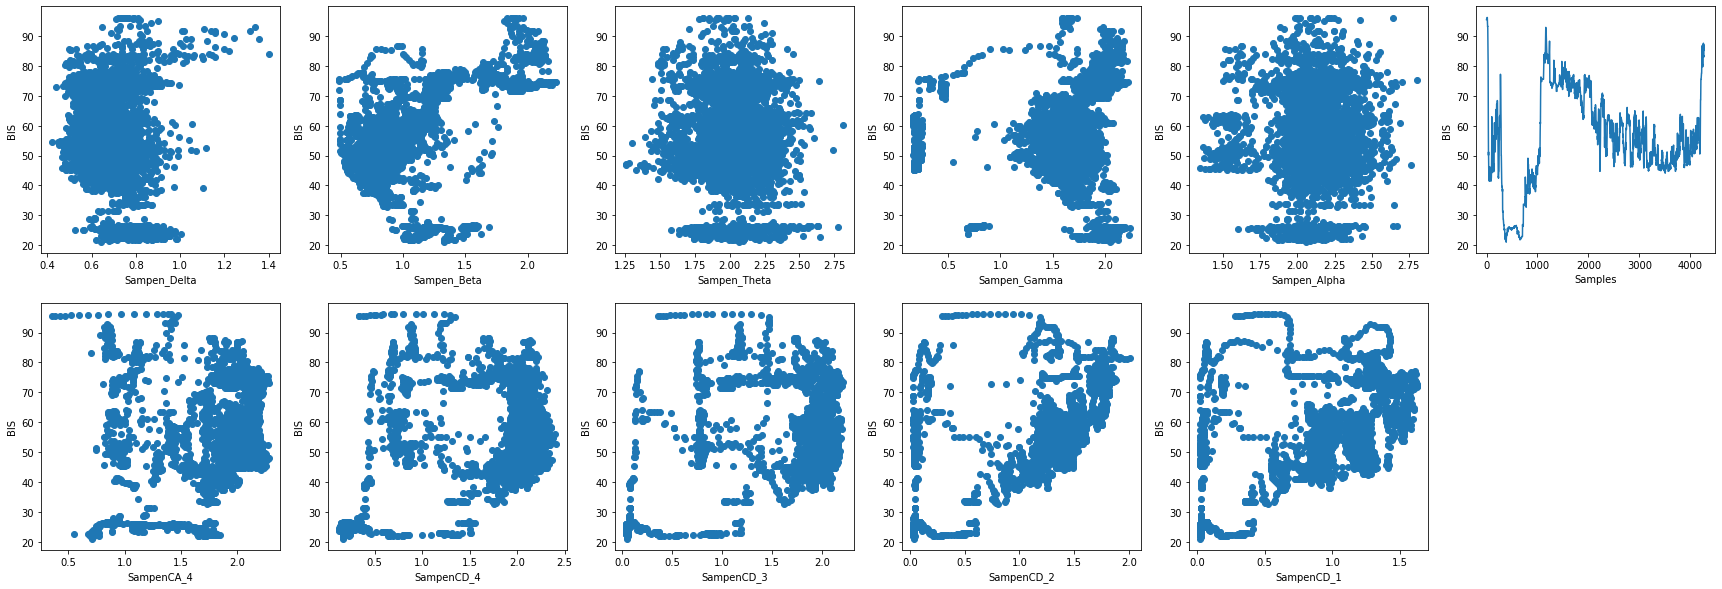

In [21]:
## Visualisations for all patients
for patient in training_set:
    print("File: {}".format(patient))
    print()
    print("A plot of the Parameters")
    print("--------------------------")
    visualise_params(patient)
    print("BIS against each parameter")
    print("--------------------------")
    visualise_params(patient, 'scatter')
    print()
    print()

<br/>

# Regression with consolidated data

The **DFT** and **DWT** data of each patient are concatenated to create a 10-feature dataset. The data is then consolidated across all patients to create a larger dataset.

In [47]:
# Import patient 1 data
patients_df = pd.read_csv("./Class A train sets/Processed Training Dataset/Modified/data.csv")

# rename the unnamed column
patients_df = patients_df.rename(columns={'Unnamed: 0': 'Sample Number'})

# Set the Sample number as index
patients_df  = patients_df.set_index('Sample Number')

patients_df.head()

Sampen_Delta  Sampen_Beta  Sampen_Theta  Sampen_Gamma  \
Sample Number                                                          
60                 0.658150     1.383708      2.252794      1.857730   
61                 0.645138     1.367389      2.320604      1.819686   
62                 0.651460     1.358295      2.085376      1.868316   
63                 0.659378     1.371857      2.194296      1.868755   
64                 0.666993     1.378257      2.507972      1.858673   

               Sampen_Alpha  SampenCA_4  SampenCD_4  SampenCD_3  SampenCD_2  \
Sample Number                                                                 
60                 2.248364    0.621993    0.237041    0.280017    0.268769   
61                 2.147214    0.641179    0.267895    0.315545    0.296700   
62                 2.354172    0.715804    0.281023    0.346876    0.322381   
63                 2.131627    0.815288    0.324438    0.382209    0.355274   
64                 2.403938    0.861407    0.371853    0.426413    0.386343   

               SampenCD_1   BIS  
Sample Number                    
60               0.263373  82.9  
61               0.290703  83.1  
62               0.313297  83.1  
63               0.341692  83.1  
64               0.367114  83.2

In [25]:
patients_df.shape

(30141, 12)

<br/>

# Performing regression

In [81]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [82]:
metrics = {}

In [105]:
def plot_regression(data, column, normalize=False):
    
    global metrics
    
    X = data[column]
    X = X[:, np.newaxis]
    y = data['BIS']

    # Perform regression
    reg = LinearRegression(n_jobs=-1, normalize=normalize).fit(X, y)
    
    # Predictions
    y_predicted = reg.predict(X)
    
    # Show the score and r2
    mse = mean_squared_error(y, y_predicted)
    r2 = r2_score(y, y_predicted)
    
    # keep track of metrics
    
    metrics["{}_mse".format(column)] = mse
    metrics["{}_r2".format(column)] = r2
    
    
    # Plot the graph
    plt.figure(figsize=(10,8))
    plt.scatter(data[column], data['BIS'], label="Data", c="steelblue")
    plt.plot(X, y_predicted, label="Regression", c="red")
    plt.xlabel(column)
    plt.ylabel('BIS')
    plt.legend(loc="upper left")
    plt.show()

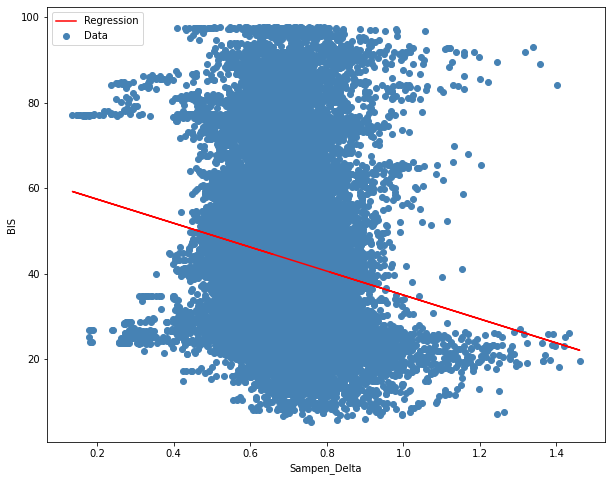

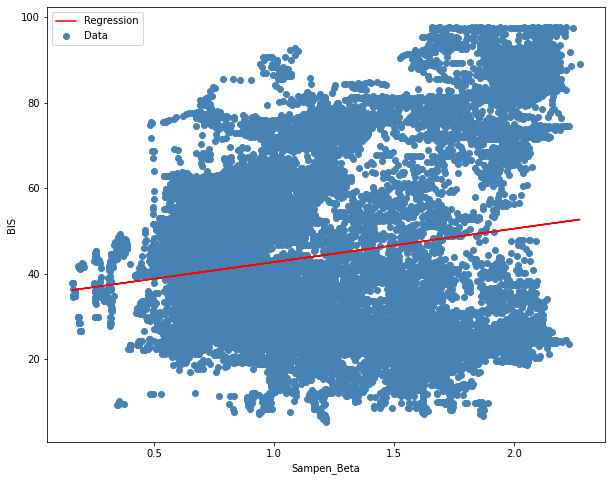

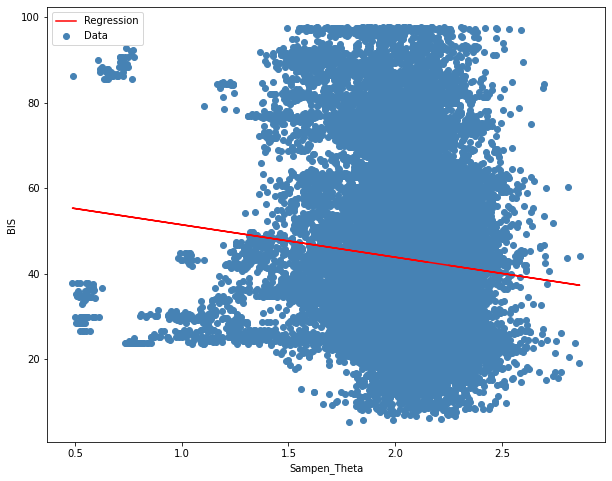

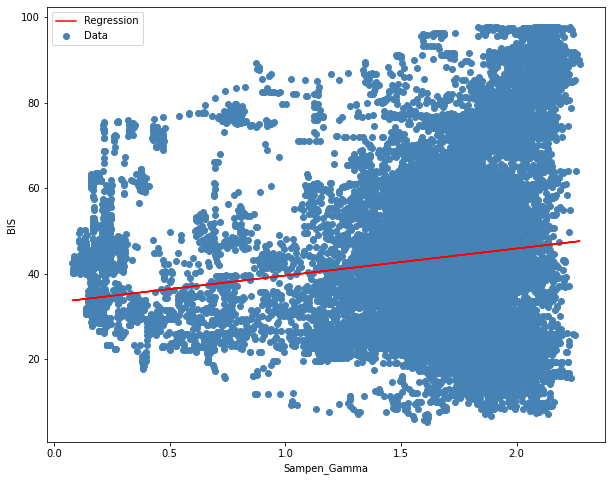

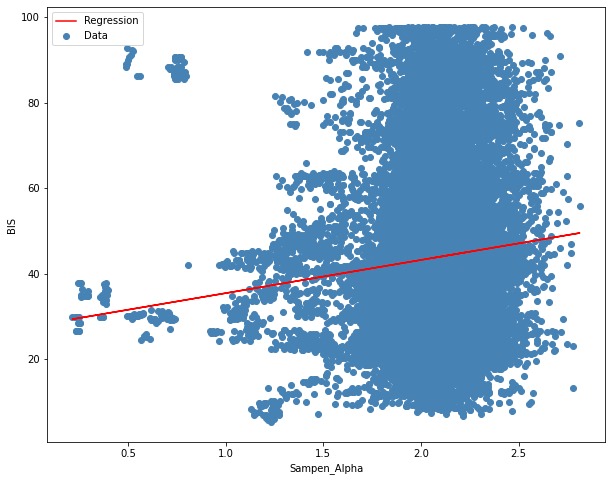

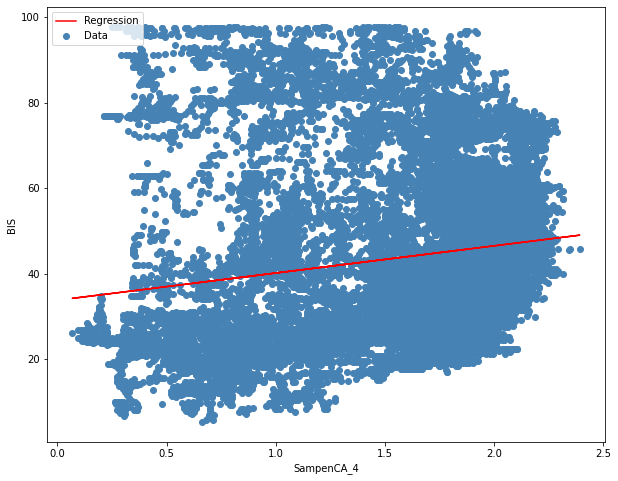

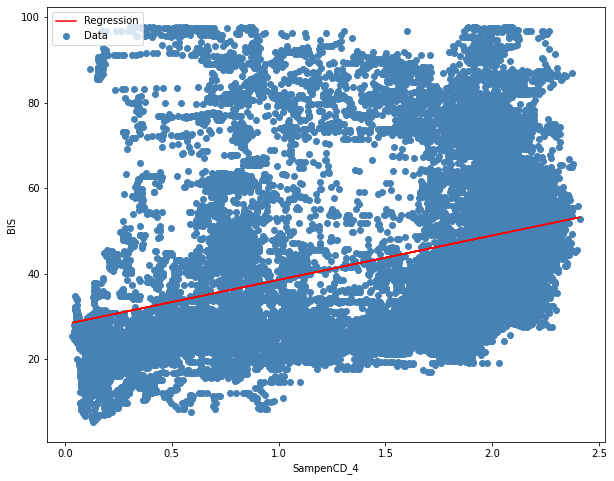

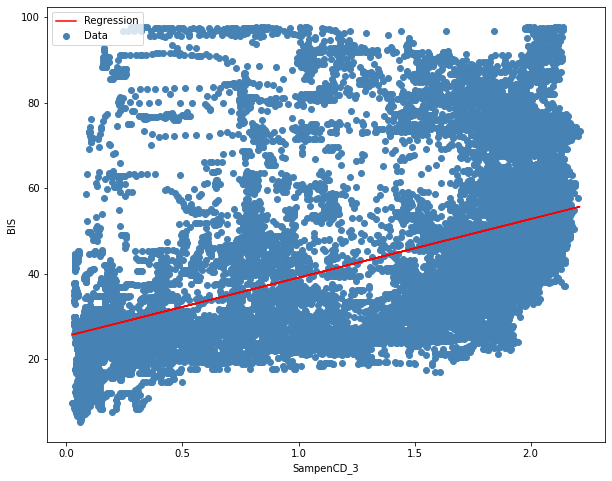

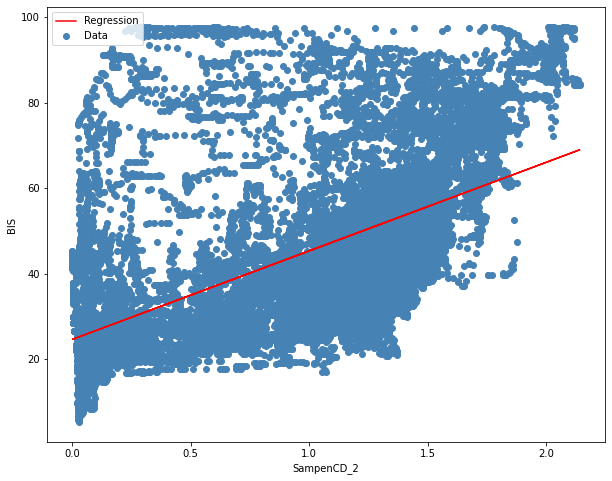

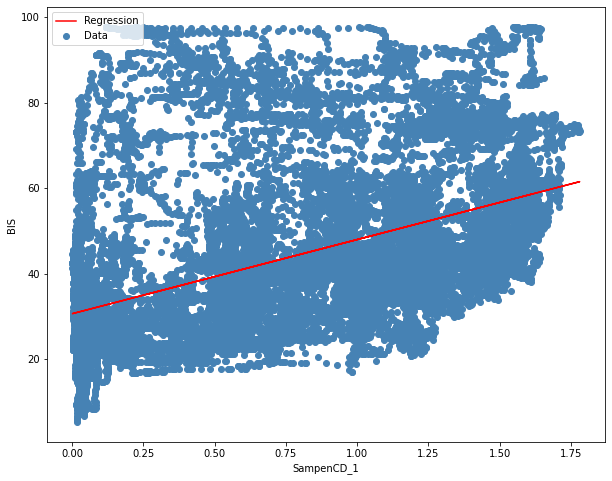

In [106]:
for column in patients_df.columns:
    if column == "BIS":
        continue
        
    plot_regression(patients_df, column)

In [107]:
# Metrics
pd.DataFrame({"Metrics": [key for key in metrics.keys()], "Values": [value for value in metrics.values()]})

Metrics      Values
0   Sampen_Delta_mse  353.317664
1    Sampen_Delta_r2    0.029748
2    Sampen_Beta_mse  352.422095
3     Sampen_Beta_r2    0.032208
4   Sampen_Theta_mse  360.648028
5    Sampen_Theta_r2    0.009618
6   Sampen_Gamma_mse  356.905771
7    Sampen_Gamma_r2    0.019895
8   Sampen_Alpha_mse  360.632167
9    Sampen_Alpha_r2    0.009662
10    SampenCA_4_mse  353.901248
11     SampenCA_4_r2    0.028146
12    SampenCD_4_mse  312.471394
13     SampenCD_4_r2    0.141917
14    SampenCD_3_mse  267.208796
15     SampenCD_3_r2    0.266213
16    SampenCD_2_mse  222.888843
17     SampenCD_2_r2    0.387921
18    SampenCD_1_mse  278.123276
19     SampenCD_1_r2    0.236241

<br/>